In [109]:
import matplotlib.pyplot as plt
import numpy as np
import os  
import pandas as pd 
from sklearn.model_selection import train_test_split
import torchvision

In [110]:
from subprocess import check_output
print(check_output(["ls", "sign_data"]).decode("utf8"))

full



In [111]:
def show_image(image,text=None, should_save=False):
    np_image = image.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    plt.show()    

In [112]:
# Define the base path for signature images
file_path = 'sign_data/full'

# Initialize an empty list to store the data
data_list = []

# List and sort the folders, then select the first 128 folders
folders = sorted(os.listdir(file_path))[:128]

for i in range(0, len(folders), 2):  # Process every second folder
    genuine_folder = folders[i]
    genuine_path = os.path.join(file_path, genuine_folder)
    forgery_path = os.path.join(file_path, genuine_folder + '_forg')
    
    # Generate all pairs of genuine signatures
    genuine_files = os.listdir(genuine_path)
    for y in genuine_files:
        for z in genuine_files:
            if y != z:
                data_list.append([os.path.join(genuine_folder, y), os.path.join(genuine_folder, z), 1])
                
    # Generate pairs of genuine and forged signatures
    if os.path.exists(forgery_path):  # Check if the forgery folder exists
        forged_files = os.listdir(forgery_path)
        for y in genuine_files:
            for z in forged_files:
                data_list.append([os.path.join(genuine_folder, y), os.path.join(genuine_folder + '_forg', z), 0])

# Create a DataFrame from the list
data = pd.DataFrame(data_list, columns=['image1', 'image2', 'label'])

# Save the DataFrame to a CSV file
data.to_csv('saved_data.csv', index=False)


In [113]:
data = pd.read_csv('saved_data.csv').sample(frac=1) 

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data.iloc[:, :2],  # Selects the first two columns as features
    data.iloc[:, 2],   # Selects the third column as the target variable
    test_size=0.2,     # Allocates 10% of the data for the test set
    stratify=data.iloc[:, 2]  # Ensures the training and testing sets have similar target variable distribution
)

In [114]:
pd.concat([X_train,y_train],axis=1).to_csv('train_data.csv',index=False)
pd.concat([X_test,y_test],axis=1).to_csv('test_data.csv',index=False)

In [115]:
data_directory = "sign_data/full"
train_csv = "train_data.csv"
test_csv = "test_data.csv"

In [116]:
class Create_Dataset(Dataset):
    
    def __init__(self, train_csv=None,train_directory=None, transform=None):
        # used to prepare the labels and images path
        self.train_dataframe=pd.read_csv(train_csv)
        self.train_dataframe.columns =["image1","image2","label"]
        self.train_directory = train_directory   
        self.transform = transform

    def __getitem__(self,index):
        
        # getting the image path
        image1_path=os.path.join(self.train_directory, self.train_dataframe.iat[index,0])
        image2_path=os.path.join(self.train_directory, self.train_dataframe.iat[index,1])
        #print(image1_path,image2_path)
        
        
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(self.train_dataframe.iat[index,2])],dtype=np.float32))
    
    def __len__(self):
        return len(self.train_dataframe)

In [117]:
dataset = Create_Dataset(train_csv, data_directory, transform=transforms.Compose([transforms.Resize((105,105)), transforms.ToTensor()]))

torch.Size([1, 1, 105, 105])


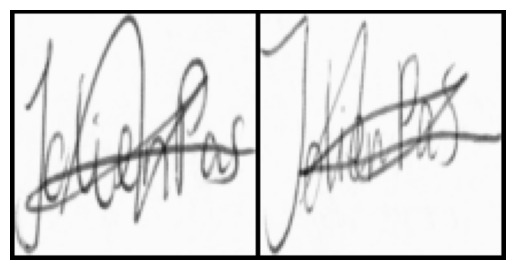

[[0.]]


In [119]:
visual_loader = DataLoader(dataset, shuffle=True, batch_size=1)
data_iterator = iter(visual_loader)


example_batch = next(data_iterator)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
print(example_batch[0].size())
show_image(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

# 0 - forged, 1 